
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- hidden layer

- Loss: cross-entropy



# Preprocessing:

Consider the each conversation as just a sequence of words:
$$
[[utt, utt, \cdots], \cdots ] \longrightarrow [[word, word , \cdots], \cdots]
$$

In here, we add a separator token "sep". It will serve to indicate when a utteration is over, and another one starts. We also add a padding token at the end to ensure that all inputs have same dimention.


In [1]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo
! pip install requests json
# eventually include tensorboard

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [2]:
import torch
import os
import matplotlib.pyplot as plt
import gensim
import json
import requests
import heapq

from nltk.tokenize import TweetTokenizer
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from collections import Counter

import pandas as pd
import numpy as np

In [325]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
! unzip wiki-news-300d-1M.vec.zip
! rm wiki-news-300d-1M.vec.zip

--2025-02-04 13:21:44--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.52.25, 18.164.52.45, 18.164.52.20, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.52.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   108MB/s    in 6.0s    

2025-02-04 13:21:51 (108 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
## taken from template
encoder_model = gensim.models.KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary = False)

In [4]:
## We create the embeddings and find the vocab
import copy
pad_token, unk_token, sep_token = '<pad>','<unk>', '<sep>'
embedding_vectors = torch.from_numpy(encoder_model.vectors) ## TODO: remove least frequent
pretrained_vocab = copy.deepcopy(encoder_model.index_to_key)
pretrained_vocab[:0] = [pad_token,sep_token,unk_token]

stoi = {word: i for i, word in enumerate(pretrained_vocab)}
itos = {i: word for i, word in enumerate(pretrained_vocab)}

pretrained_embeddings = torch.cat((torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))
pretrained_embeddings = torch.cat((-torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))
pretrained_embeddings = torch.cat((torch.zeros(1,embedding_vectors.shape[1]),embedding_vectors))


In [5]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

max_size = 200
## By using the template that was shared, we can process the inputs in a very similar way
tok = TweetTokenizer()
def tokenize_text_extend_emotions(text,emotion,stoi): ## utteration : string -> list of tokenized words : [int]
  text = tok.tokenize(text)
  text = [stoi[word] if word in stoi else stoi['<unk>'] for word in text]
  emotion = [ f"{emotion}_{i}" for i in range(len(text))]
  decoded_emotions = [i.split('_')[0] for i in emotion]

  return text, emotion,decoded_emotions

def concat_utt(dialog, emotions,stoi, max_size=max_size): ## list of utterations : [string] -> list of list of tokenized words : [int]
  tokenized_and_extended = [tokenize_text_extend_emotions(t,e,stoi) for t,e in zip(dialog,emotions)]
  dialog = [i[0] for i in tokenized_and_extended]
  emotions = [i[1] for i in tokenized_and_extended]
  decoded_emotions = [i[2] for i in tokenized_and_extended]
  dialog_flat = []
  emotions_extended = ['NE']
  decoded_emotions_extended = ['NE']
  for i in range(len(dialog) - 1):
    dialog[i].append(stoi["<sep>"])
    emotions[i].append('NE') ## number of emotions
    decoded_emotions[i].append('NE')
  for i in range(len(dialog)):
    dialog_flat.extend(dialog[i])
    emotions_extended.extend(emotions[i])
    decoded_emotions_extended.extend(decoded_emotions[i])
  if len(emotions_extended) > max_size:
    dialog_flat = dialog_flat[:max_size]
    emotions_extended = emotions_extended[:max_size]
    decoded_emotions_extended = decoded_emotions_extended[:max_size]
  else:
    dialog_flat.extend([0]*(max_size - len(dialog_flat)))
    emotions_extended.extend(['NE']*(max_size - len(emotions_extended)))
    decoded_emotions_extended.extend(['NE']*(max_size - len(decoded_emotions_extended)))
  return dialog_flat,emotions_extended,decoded_emotions_extended

def preprocess_data(X,Y,stoi): ## list of lists of utterations : [[string]] -> list of lists of tokenized words : [[int]]
  X_processed = []
  Y_processed = []
  dec_processed = []
  for i in tqdm(range(len(X))):
    x,y,dec = concat_utt(X[i],Y[i],stoi)
    X_processed.append(x)
    Y_processed.append(y)
    dec_processed.append(dec)
  return X_processed, Y_processed, dec_processed

def get_target(X,Y,dec): ## generates the target values and input values
  text_input = [i[:-1] for i in X]
  text_target = [i[1:] for i in X]
  emotion_input = [i[:-1] for i in Y]
  emotion_target = [i[1:] for i in Y]
  
  dec_input = [i[:-1] for i in dec]
  dec_target = [i[1:] for i in dec]
  for i in range(len(text_target)):
    for j in range(len(text_target[i])):
      if text_target[i][j] == 2:
          emotion_target[i][j] = -1
      if text_target[i][j] == 0:
        emotion_target[i][j] = -1
        text_target[i][j] = -1
  return text_input, text_target, emotion_input, emotion_target, dec_input, dec_target

# stoi = {'<pad>':0,'<unk>' : 1, '<sep>' : 2}

## Check the following example:
dialog_example = ["hello, I am a I robot!","I am greek"]
emotions_example = ['happy','happy'] ## random emotions...

flatten_dialog, flatten_emotions, dec_emotions = concat_utt(dialog_example,emotions_example,stoi,max_size=20)
print(f"{dialog_example} becomes {flatten_dialog}")
print(f"{emotions_example} becomes {flatten_emotions}")
print(f"We additionally get {dec_emotions}", len(dec_emotions))


['hello, I am a I robot!', 'I am greek'] becomes [13172, 3, 31, 784, 10, 31, 6872, 80, 1, 31, 784, 22505, 0, 0, 0, 0, 0, 0, 0, 0]
['happy', 'happy'] becomes ['NE', 'happy_0', 'happy_1', 'happy_2', 'happy_3', 'happy_4', 'happy_5', 'happy_6', 'happy_7', 'NE', 'happy_0', 'happy_1', 'happy_2', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE']
We additionally get ['NE', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'NE', 'happy', 'happy', 'happy', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE'] 20


## DataLoader:

In [6]:
## Modify this after changing the preprocessing.
class CustomedDataset(Dataset):
  def __init__(self, texts, emotions,decoded_emotions,target_texts,target_emotions,target_decoded_emotions):
  # Dataset object for Daily Dialog dataset
    self.texts = texts                       ## tokenized text
    self.emotions = emotions                 ## tokenized emotions
    self.decoded_emotions = decoded_emotions 
    self.target_texts = target_texts         ## target text for loss computation
    self.target_emotions = target_emotions   ## target emotions for loss computation
    self.target_decoded_emotions = target_decoded_emotions

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                'texts': np.array(self.texts[idx]),
             'emotions': np.array(self.emotions[idx]),
         'target_texts': np.array(self.target_texts[idx]),
      'target_emotions': np.array(self.target_emotions[idx]),
                  'dec': np.array(self.decoded_emotions[idx]),
           'target_dec': np.array(self.target_decoded_emotions[idx])
    }
    return item


Here we will extract the data and process it:

In [201]:
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/dev_sent_emo.csv
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/test_sent_emo.csv
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/train_sent_emo.csv

--2025-02-03 11:55:40--  https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/dev_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121640 (119K) [text/plain]
Saving to: ‘dev_sent_emo.csv.21’

dev_sent_emo.csv.21 100%[===================>] 118.79K  --.-KB/s    in 0.02s   

2025-02-03 11:55:40 (6.01 MB/s) - ‘dev_sent_emo.csv.21’ saved [121640/121640]

--2025-02-03 11:55:40--  https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/test_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting res

In [7]:
#data_dd = load_dataset('daily_dialog') ## daily conversations
"""
data_meld_train = pd.read_csv('train_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])
data_meld_val = pd.read_csv('dev_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])
data_meld_test = pd.read_csv('test_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])
"""
## For Daily Dialog:
"""
X_train_dd = data_dd['train']['dialog']
Y_train_dd = data_dd['train']['emotion']
X_test_dd = data_dd['test']['dialog']
Y_test_dd = data_dd['test']['emotion']
X_val_dd = data_dd['validation']['dialog']
Y_val_dd = data_dd['validation']['emotion']
"""

def change_Y(Y,unk='NE',lookup=None):
  found = (lookup is None) ## True if not passed (train) False else
  lookup = {} if (lookup is None) else lookup ## {} if not passed {train} False else
  k = 0
  for i in range(len(Y)):
    for j in range(len(Y[i])):
      if (Y[i][j] not in lookup) and found: ## if train and Y is not in lookup then add Y to lookup.keys()
        lookup[Y[i][j]] = k
        Y[i][j] = k
        k += 1
        continue
      elif Y[i][j] in lookup: ## if Y in lookup then assign different value..
        Y[i][j] = lookup[Y[i][j]]
        continue
      elif not found: # if it is passed but Y not in
        Y[i][j] = lookup[unk]  
  return Y, lookup



def parse_meld(df,lookup = None):
  X, Y = {}, {}
  for _, row in df.iterrows():
    dialog_id = row['Dialogue_ID']
    if dialog_id not in X:
      X[dialog_id] = []
      Y[dialog_id] = []
    X[dialog_id].append(row['Utterance'])
    Y[dialog_id].append(row['Emotion'])
  X = list(X.values())
  Y = list(Y.values())
  return X, Y
"""
X_train_meld, Y_train_meld, lookup_meld = parse_meld(data_meld_train)
X_test_meld, Y_test_meld, _ = parse_meld(data_meld_test,lookup_meld)
X_val_meld, Y_val_meld, _ = parse_meld(data_meld_val,lookup_meld)

"""
## For EmoryNLP:
def parse_seasons(episodes,lookup=None): ## annoying parsing
  lookup = {} if lookup is None else lookup
  X = []
  Y = []
  for episode in episodes:
    for scene in episode['scenes']:
      dialog = []
      emotion = []
      for utterance in scene['utterances']:
        if utterance['transcript'] != '':
          dialog.append(utterance['transcript'])
          emotion.append(utterance['emotion'])
      X.append(dialog)
      Y.append(emotion)
  return X, Y

def parse_emory(): ## getting from the web
  json_train = 'https://raw.githubusercontent.com/emorynlp/emotion-detection/refs/heads/master/json/emotion-detection-trn.json'
  json_test = 'https://raw.githubusercontent.com/emorynlp/emotion-detection/refs/heads/master/json/emotion-detection-dev.json'
  json_val = 'https://raw.githubusercontent.com/emorynlp/emotion-detection/refs/heads/master/json/emotion-detection-tst.json'
  train = requests.get(json_train)
  test = requests.get(json_test)
  val = requests.get(json_val)

  train = json.loads(train.text)['episodes']
  test = json.loads(test.text)['episodes']
  val = json.loads(val.text)['episodes']
  X_train, Y_train = parse_seasons(train)
  X_test, Y_test = parse_seasons(test)
  X_val, Y_val = parse_seasons(val)
  return X_train, Y_train, X_test, Y_test, X_val, Y_val


## to get top n most frequent words:
def get_topk(X,k,pretrained_embeddings,embedding_vectors): ## get the top k most frequent words - has to get a flatten version of the input
  X = [j for i in X for j in i]
  flat_X = []
  for i in X:
    flat_X.extend(tok.tokenize(i))
  c = Counter(flat_X)
  print(len(c))
  top_k = heapq.nlargest(k, c.items(), key=lambda x: x[1])
  new_stoi = {'<pad>':0,'<unk>' : 1, '<sep>' : 2}
  res = []
  k = 3
  for (word,_) in top_k:
    if word in stoi:
      new_stoi[word] = k
      k += 1
      res.append(pretrained_embeddings[stoi[word]])

  res[:0] = [torch.ones(embedding_vectors.shape[1]),-torch.ones(embedding_vectors.shape[1]),torch.zeros(embedding_vectors.shape[1])]
  new_itos = {index : word for (word,index) in new_stoi.items()}
  return torch.stack(res), new_stoi, new_itos

X_train_emory, Y_train_emory, X_test_emory, Y_test_emory, X_val_emory, Y_val_emory = parse_emory()
embeddings_emory, stoi_emory,itos_emory = get_topk(X_train_emory, 100000, pretrained_embeddings, embedding_vectors)


7988


In [8]:
# For Daily Dialog (probably not going to be used anymore)
""" 
X_train_dd, Y_train_dd = preprocess_data(X_train_dd,Y_train_dd)
X_train_dd,X_train_target_dd, Y_train_dd, Y_train_target_dd = get_target(X_train_dd,Y_train_dd)
X_test_dd, Y_test_dd = preprocess_data(X_test_dd,Y_test_dd)
X_test_dd,X_test_target_dd, Y_test_dd, Y_test_target_dd = get_target(X_test_dd,Y_test_dd)
X_val_dd, Y_val_dd = preprocess_data(X_val_dd,Y_val_dd)
X_val_dd, X_val_target_dd, Y_val_dd, Y_val_target_dd = get_target(X_val_dd,Y_val_dd)
"""
# For MELD
"""
X_train_meld, Y_train_meld = preprocess_data(X_train_meld,Y_train_meld)
X_train_meld,X_train_target_meld, Y_train_meld, Y_train_target_meld = get_target(X_train_meld,Y_train_meld)
X_test_meld, Y_test_meld = preprocess_data(X_test_meld,Y_test_meld)
X_test_meld,X_test_target_meld, Y_test_meld, Y_test_target_meld = get_target(X_test_meld,Y_test_meld)
X_val_meld, Y_val_meld = preprocess_data(X_val_meld,Y_val_meld)
X_val_meld, X_val_target_meld, Y_val_meld, Y_val_target_meld = get_target(X_val_meld,Y_val_meld)
"""
## For EmoryNLP:
X_train_emory, Y_train_emory, dec_train_emory = preprocess_data(X_train_emory,Y_train_emory,stoi_emory)


Y_train_emory, lookup_emory = change_Y(Y_train_emory)
dec_train_emory, dec_lookup_emory = change_Y(dec_train_emory)
X_train_emory,X_train_target_emory, Y_train_emory, Y_train_target_emory, dec_train_emory, dec_train_target_emory = get_target(X_train_emory,Y_train_emory,dec_train_emory)

X_test_emory, Y_test_emory,dec_test_emory = preprocess_data(X_test_emory,Y_test_emory,stoi_emory)
Y_test_emory, _ = change_Y(Y_test_emory,lookup=lookup_emory)
dec_test_emory, _ = change_Y(dec_test_emory,lookup=dec_lookup_emory)
X_test_emory,X_test_target_emory, Y_test_emory, Y_test_target_emory, dec_test_emory,dec_test_target_emory = get_target(X_test_emory,Y_test_emory,dec_test_emory)

X_val_emory, Y_val_emory,dec_val_emory = preprocess_data(X_val_emory,Y_val_emory,stoi_emory)
Y_val_emory, _ = change_Y(Y_val_emory,lookup=lookup_emory)
dec_val_emory, _ = change_Y(dec_val_emory,lookup=dec_lookup_emory)
X_val_emory, X_val_target_emory, Y_val_emory, Y_val_target_emory,dec_val_emory, dec_val_target_emory = get_target(X_val_emory,Y_val_emory,dec_val_emory)
## Just checking if nothing wrong happened


  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

In [9]:
batch_size = 5 ## try with other values. 5 Might be too little!
"""
## DailyDialog Dataset:
train_data_dd = DailyDialogDataset(X_train_dd,Y_train_dd,X_train_target_dd,Y_train_target_dd)
test_data_dd = DailyDialogDataset(X_test_target_dd,Y_test_target_dd,X_test_target_dd,Y_test_target_dd)
val_data_dd = DailyDialogDataset(X_val_target_dd,Y_val_target_dd,X_val_target_dd,Y_val_target_dd)

## MELD Dataset:
train_data_meld = MeldDataset(X_train_meld,Y_train_meld,X_train_target_meld,Y_train_target_meld)
test_data_meld = MeldDataset(X_test_meld,Y_test_meld,X_test_target_meld,Y_test_target_meld)
val_data_meld = MeldDataset(X_val_meld,Y_val_meld,X_val_target_meld,Y_val_target_meld)
"""
## EmoryNLP Datset:
train_data_emory = CustomedDataset(X_train_emory,Y_train_emory,dec_train_emory, X_train_target_emory,Y_train_target_emory, dec_train_target_emory)
test_data_emory = CustomedDataset(X_test_emory,Y_test_emory,dec_test_emory,X_test_target_emory,Y_test_target_emory,dec_test_target_emory)
val_data_emory = CustomedDataset(X_val_emory,Y_val_emory,dec_val_emory,X_val_target_emory,Y_val_target_emory,dec_val_target_emory)


"""
train_loader_dd = DataLoader(train_data_dd, batch_size=batch_size,shuffle = True,)
test_loader_dd = DataLoader(test_data_dd, batch_size=batch_size,shuffle = True)
val_loader_dd = DataLoader(val_data_dd, batch_size=batch_size, shuffle = True)

train_loader_meld = DataLoader(train_data_meld, batch_size=batch_size,shuffle = True,)
test_loader_meld = DataLoader(test_data_meld, batch_size=batch_size,shuffle = True)
val_loader_meld = DataLoader(val_data_meld, batch_size=batch_size, shuffle = True)
"""
train_loader_emory = DataLoader(train_data_emory, batch_size=batch_size,shuffle = True)
test_loader_emory = DataLoader(test_data_emory, batch_size=batch_size,shuffle = True)
val_loader_emory = DataLoader(val_data_emory, batch_size=batch_size, shuffle = True)


# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- hidden state being updated every itteration
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [31]:
def cast_back_aux(words,preds): ## from multiple labels, choose the most popular one for the whole utterance
    current_dialog = []
    counter = dict()
    sentences = []
    current_sentence = []
    assert(len(words) == len(preds))
    for i, (word, pred_emotion) in enumerate(zip(words,preds)):
        if word == '<pad>':
            if len(list(counter.keys())) > 0:
                sorted_counter = sorted(counter.items(),key = lambda e : e[1])[::-1]
                current_dialog.append(sorted_counter[0][0]) ## add most frequent
                sentences.append(current_sentence)
                current_sentence = []
                counter = dict()
                continue
            continue
        elif word == '<sep>':
            sorted_counter = sorted(counter.items(),key = lambda e : e[1])[::-1]
            current_dialog.append(sorted_counter[0][0]) ## add most frequent
            counter = dict()
            sentences.append(current_sentence)
            current_sentence = []
            continue
        elif word != '<sep>' and word != '<pad>':
            if word != '<pad>':
                current_sentence.append(word)
            if pred_emotion not in counter:
                counter[pred_emotion.split('_')[0]] = 0
            counter[pred_emotion.split('_')[0]] += 1
            if i == len(words) - 1:
                sorted_counter = sorted(counter.items(),key = lambda e : e[1])[::-1]
                current_dialog.append(sorted_counter[0][0]) ## add most frequent
                counter = dict()
                sentences.append(current_sentence)
                current_sentence = []
    return current_dialog, sentences

def cast_back(words,emotions,itos,lookup): #tokenized input
    words = list(map(lambda e : itos[e] ,words))
    emotions = list(map(lambda e : lookup[e] ,emotions))
    return cast_back_aux(words,emotions)

In [217]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleModel(nn.Module):
    def __init__(self, embeddings,emo_dim, n_emotion, n_vocab,n_dec):
        super(SimpleModel,self).__init__()
        ## word_dim = 300
        self.embedding_layer_text = nn.Embedding.from_pretrained(embeddings, freeze=True)
        self.embedding_layer_emotion = nn.Embedding(n_emotion, emo_dim)
        ## Channel for utterances/words:
        self.Linear_utt1 = nn.Linear(300,600)
        self.Linear_utt2 = nn.Linear(600,800)
        self.Linear_utt3 = nn.Linear(800,400)
        
        ## Channel for emotions:
        self.Linear_emo1 = nn.Linear(emo_dim,600)
        self.Linear_emo2 = nn.Linear(600,800)
        self.Linear_emo3 = nn.Linear(800,400)
        # self.Linear_emo3.requires_grad = False

        ## fusion by concatenation and Linear layer:
        self.Linear_fus = nn.Linear(800,500)
        self.Hidden_weight = nn.Linear(400,400)
    
        ## We concatenate and do linear again (2 different concatenations)
        self.Linear_utt_final1 = nn.Linear(400 + 400  + 500, 500)
        self.Linear_utt_final2 = nn.Linear(500, 600)
        self.Linear_utt_final3 = nn.Linear(600, 1000)
        self.Linear_utt_final = nn.Linear(1000, n_vocab) ## test remove unk and sep from teh predictions to see if it improves somethings (answer: not really)


        self.Linear_emo_final1 = nn.Linear(400 + 500 , 600)
        self.Linear_emo_final2 = nn.Linear(600, 700)
        self.Linear_emo_final3 = nn.Linear(700, n_emotion)
    
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=0)
        self.Dropout = nn.Dropout(p = 0.5)
      
    def forward(self, text, emotion, hidden):
        text1 = self.embedding_layer_text(text)
        text2 = self.Linear_utt1(text1)
        text3 = self.relu(text2)
        text4 = self.Linear_utt2(text3)
        text5 = self.relu(text4)
        text6 = self.Linear_utt3(text5)

        emotion1 = self.embedding_layer_emotion(emotion)
        emotion2 = self.Linear_emo1(emotion1)
        emotion3 = self.Linear_emo2(emotion2)
        emotion4 = self.Linear_emo3(emotion3)

        hidden1 = hidden + self.Hidden_weight(emotion4*0.7 + text6*0.3)
        hidden2 = self.Dropout(hidden1)
        hidden3 = self.tanh(hidden2)

        z = torch.cat((text6,emotion4),-1)
        z1 = self.Linear_fus(z)
    
        emotion5 = torch.cat((text6,z1),-1)
        emotion6 = self.Linear_emo_final1(emotion5)
        emotion7 = self.Dropout(emotion6)
        emotion8 = self.Linear_emo_final2(emotion7)    
        emotion9 = self.Dropout(emotion8)
        emotion10 = self.relu(emotion9)
        emotion11 = self.Linear_emo_final3(emotion10)
        emotion12 = self.softmax(emotion11)

        text7 = torch.cat((z1,hidden3,text6),-1)
        text8 = self.Linear_utt_final1(text7)
        text9 = self.relu(text8)
        text10 = self.Linear_utt_final2(text9)
        text11 = self.Dropout(text10)
        text12 = self.Linear_utt_final3(text11)
        text13 = self.Dropout(text12)
        text14 = self.Linear_utt_final(text13)
        text15 = self.softmax(text14)
        return text15, emotion12, hidden3
    #return emotion


In [218]:
from torchinfo import summary

def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

## Setting some hyper parameters:
device = activate_gpu()
emotion_dim = 300

n_emotions = len(lookup_emory)
n_words = len(stoi_emory)
n_dec = len(dec_lookup_emory)
print(dec_lookup_emory)
## selecting some hyper parameter

model = SimpleModel(embeddings_emory,emotion_dim,n_emotions,n_words,n_dec)
print(device)
print(summary(model))

DEVICE =  CPU blue
{'NE': 0, 'Joyful': 1, 'Neutral': 2, 'Powerful': 3, 'Mad': 4, 'Sad': 5, 'Scared': 6, 'Peaceful': 7}
cpu
Layer (type:depth-idx)                   Param #
SimpleModel                              --
├─Embedding: 1-1                         (2,098,200)
├─Embedding: 1-2                         234,000
├─Linear: 1-3                            180,600
├─Linear: 1-4                            480,800
├─Linear: 1-5                            320,400
├─Linear: 1-6                            180,600
├─Linear: 1-7                            480,800
├─Linear: 1-8                            320,400
├─Linear: 1-9                            400,500
├─Linear: 1-10                           160,400
├─Linear: 1-11                           650,500
├─Linear: 1-12                           300,600
├─Linear: 1-13                           601,000
├─Linear: 1-14                           7,000,994
├─Linear: 1-15                           540,600
├─Linear: 1-16                           42

In [219]:
from sklearn.metrics import f1_score

def get_frequency_all(batches,n_total=len(lookup_emory)):
    freq_dict = {i:0 for i in range(n_total)}
    for batch in batches:
        c = dict(Counter(batch['target_emotions'].view(-1).tolist()))
        for tens,freq in c.items():
            if tens!=-1:
                freq_dict[tens] += freq
    for i in freq_dict:
        if i != 0:
            if freq_dict[i] != 0:
                freq_dict[i] = 1/(freq_dict[i] + 1e-6)
        if freq_dict[i] < 0.05:
            freq_dict[i] /= 10
        if freq_dict[i] > 10:
            freq_dict[i] = 0
            
    freq_dict[0] = 0.0000001
    return F.normalize(torch.tensor(list(freq_dict.values()),dtype=torch.float32),dim=0)

def inference(model,loader,device,weights=None):
    model.eval()
    model = model.to(device)
    preds = []
    trues = []
    words = []
    pred_words = []
    losses = []
    for batch in tqdm(loader,total=loader.__len__()):
        batch = {          
                         'texts' : batch['texts'].to(device),
                      'emotions' : batch['emotions'].to(device),
                  'target_texts' : batch['target_texts'].to(device),
               'target_emotions' : batch['target_emotions'].to(device),
                           'dec' : batch['dec'].to(device)
        }
        mask = (batch['target_texts'] != -1).float()
        loss_fn = nn.CrossEntropyLoss(ignore_index=-1) if weights is None else nn.CrossEntropyLoss(weight=weights,ignore_index=-1)
        inp_emotion = torch.tensor([0]*batch['target_texts'].size()[0]).to(device)
        hidden = torch.zeros((batch['texts'].size()[0],400)).to(device)
        loss = 0
        for t in range(batch['texts'].size()[1]):
            inp_token = batch['texts'][:, t]
            target_token = batch['target_texts'][:, t]
            target_emotion = batch['target_emotions'][:, t]
            pt , pe,hidden = model.forward(inp_token,inp_emotion,hidden)
            pred_emotion = torch.argmax(pe,1)
            pred_token = torch.argmax(pt,1)
            if target_token.size()[0] == 5:
                preds.append(pred_emotion)
                trues.append(target_emotion)
                words.append(target_token)
                pred_words.append(pred_token)
            if mask[:,t].sum().item() == 0:  ## if it has to stop, then append first
                continue
            loss += 0.7*loss_fn(pe, target_emotion)/5
            inp_emotion = pred_emotion
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                continue
        losses.append(loss.mean().item())
    trues = torch.stack(trues)
    preds = torch.stack(preds)
    words = torch.stack(words)
    pred_words = torch.stack(pred_words)
    new_trues = []
    new_preds = []
    new_words = []
    new_pred_words = []
    for i in range(trues.size()[1]):
        new_preds.append(preds[:, i])
        new_trues.append(trues[:, i])
        new_words.append(words[:, i])
        new_pred_words.append(pred_words[:,i])
    pred_words = torch.stack(new_pred_words).view(-1).tolist()
    preds = torch.stack(new_preds).view(-1).tolist()
    trues = torch.stack(new_trues).view(-1).tolist()
    words = torch.stack(new_words).view(-1).tolist()
    return f1_score(preds,trues,average='macro'), sum(losses)/len(losses),preds,trues,words,pred_words

In [220]:
_, _, preds, trues, words, pred_words = inference(model,train_loader_emory,device)

  0%|          | 0/143 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [221]:
from sklearn.metrics import classification_report, confusion_matrix
emory_lookup = {m:n for (n,m) in lookup_emory.items()}
emory_lookup[-1] = 'NE'
itos_emory[-1] = '<pad>'
preds_utt, _  = cast_back(words,preds,itos_emory,emory_lookup)
trues_utt, sentences = cast_back(words,trues,itos_emory,emory_lookup)
print(classification_report(trues_utt,preds_utt))


              precision    recall  f1-score   support

      Joyful       0.23      0.15      0.18       227
         Mad       0.05      0.08      0.06        83
          NE       0.00      0.00      0.00         0
     Neutral       0.32      0.19      0.24       293
    Peaceful       0.14      0.18      0.16       123
    Powerful       0.13      0.15      0.14       114
         Sad       0.05      0.09      0.06        75
      Scared       0.13      0.14      0.14       139

    accuracy                           0.15      1054
   macro avg       0.13      0.12      0.12      1054
weighted avg       0.19      0.15      0.16      1054



/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [239]:
import torch.optim as optim
from tqdm.notebook import tqdm

def train_batch(model, batch, optimizer,lr,weights=None): ## train for each batch (set to size 1 in this case)
    loss = 0
    loss_words = nn.CrossEntropyLoss(ignore_index=-1)
    loss_emotions = nn.CrossEntropyLoss(ignore_index=-1) if weights is None else nn.CrossEntropyLoss(weight=weights,ignore_index=-1)
    hidden = torch.zeros((batch['texts'].size()[0],400), requires_grad=True).to(device)
    losses = []
    mask = (batch['target_emotions'] != -1).float()
    for t in range(55):#batch['texts'].size()[1]):
        
        if mask[:,t].sum().item() == 0:
            continue
        inp_emotion = batch['emotions'][:, t]
        inp_token = batch['texts'][:, t]
        target_token = batch['target_texts'][:, t]
        target_emotion = batch['target_emotions'][:, t]
        pt, pe, hidden = model.forward(inp_token,inp_emotion,hidden)
        loss1 = 0.7 * loss_emotions(pe, target_emotion)
        loss2 = 0.3 * loss_words(pt, target_token)
        if torch.isnan(loss1).any() or torch.isinf(loss1).any():
            continue
        if torch.isnan(loss2).any() or torch.isinf(loss2).any():
            continue
        loss += loss1 + loss2
        losses.append(loss1.mean().item()/5)
        loss.backward(retain_graph=True)
    optimizer.step()
    if len(losses) == 0:
      return 0
    else:
        return sum(losses)/(len(losses)) ## average of the loss over the emotions


def train(model, train_loader, epochs, device,lr=0.01,compute_preds = False):
    optimizer = optim.SGD(model.parameters(),lr=lr)
    #scheduler = StepLR(optimizer, step_size=300), gamma=0.1) ## Adding this for some reason doesn't allow the model to learn well
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    model = model.to(device)
    loss_to_plot = []
    weights = get_frequency_all(train_loader).to(device)
    for epoch in range(epochs):
        optimizer.zero_grad()
        losses = []
        print(f"Epoch {epoch+1}/{epochs}")
        if compute_preds:
            f1, loss, _, _, _, _ = inference(model, train_loader,device,weights)
            print(f'f1: {f1}, loss: {loss}')
        for it, batch in tqdm(enumerate(train_loader),total = train_loader.__len__()):
            batch = {          
                         'texts' : batch['texts'].to(device),
                      'emotions' : batch['emotions'].to(device),
                  'target_texts' : batch['target_texts'].to(device),
               'target_emotions' : batch['target_emotions'].to(device),
                           'dec' : batch['dec'].to(device)
            }
            losses.append(train_batch(model, batch, optimizer,lr,weights=weights))
        loss_to_plot.append(sum(losses)/len(losses))
        print(f"training loss: {loss_to_plot[-1]}")
    return loss_to_plot


In [240]:
# train and plot:

epochs = 10
losses = train(model, train_loader_emory, epochs, device)
plt.plot(np.arange(1,epochs+1), losses)

Epoch 1/10


  0%|          | 0/143 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [241]:
_, _ ,preds, trues, words, pred_words = inference(model,val_loader_emory,device)
emory_lookup = {m:n for (n,m) in lookup_emory.items()}
emory_lookup[-1] = 'NE' # no emotion
itos_emory[-1] = '<pad>' 

"""
 3.5998e-02,  3.5775e-02, -3.6551e-02,  ..., -1.5928e-02,
         -2.7912e-02,  4.6422e-02],
        [-4.4213e-02,  1.3502e-02,
"""

  0%|          | 0/17 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0491,  0.0363, -0.0193,  ..., -0.0316, -0.0143, -0.0321],
        [ 0.0488, -0.0011, -0.0192,  ...,  0.0296, -0.0073,  0.0258],
        [ 0.0357,  0.0107,  0.0130,  ...,  0.0143,  0.0233, -0.0023],
        ...,
        [-0.0110,  0.0322,  0.0309,  ...,  0.0204,  0.0403, -0.0502],
        [-0.0319,  0.0047,  0.0102,  ..., -0.0253,  0.0097, -0.0002],
        [-0.0412, -0.0378, -0.0110,  ...,  0.0105, -0.0307, -0.0081]],
       requires_grad=True)


'\n 3.5998e-02,  3.5775e-02, -3.6551e-02,  ..., -1.5928e-02,\n         -2.7912e-02,  4.6422e-02],\n        [-4.4213e-02,  1.3502e-02,\n'

In [242]:
from sklearn.metrics import classification_report, confusion_matrix

casted_preds, sentences = cast_back(words,preds,itos_emory,emory_lookup)
casted_trues, _ = cast_back(words,trues,itos_emory,emory_lookup)
to_remove = []
for i in range(len(casted_trues)):
    if casted_trues[i] == 'NE':
        to_remove.append(i)

for i in to_remove[::-1]:
    casted_trues.pop(i)
    casted_preds.pop(i)
    sentences.pop(i)
print(confusion_matrix(casted_trues,casted_preds))
print(classification_report(casted_trues,casted_preds))

d = Counter(casted_preds) ## 
print(d)

assert(len(sentences) == len(casted_trues))
for a,b,c in zip(casted_trues,casted_preds, sentences):
    print(f"true emotions: {a} -- predicted emotion: {b}")
    print(f"sentence: {' '.join(c)}")
    print('\n')

[[ 31  13   1  79   2   0 102]
 [ 14   3   2  40   1   1  22]
 [ 34   8   4  90   4   2 151]
 [ 15   7   0  38   0   0  63]
 [ 21  10   0  43   2   0  38]
 [ 11   4   1  26   0   1  32]
 [ 31   7   1  45   0   0  54]]
              precision    recall  f1-score   support

      Joyful       0.20      0.14      0.16       228
         Mad       0.06      0.04      0.04        83
     Neutral       0.44      0.01      0.03       293
    Peaceful       0.11      0.31      0.16       123
    Powerful       0.22      0.02      0.03       114
         Sad       0.25      0.01      0.03        75
      Scared       0.12      0.39      0.18       138

    accuracy                           0.13      1054
   macro avg       0.20      0.13      0.09      1054
weighted avg       0.24      0.13      0.09      1054

Counter({'Scared': 462, 'Peaceful': 361, 'Joyful': 157, 'Mad': 52, 'Powerful': 9, 'Neutral': 9, 'Sad': 4})
true emotions: Neutral -- predicted emotion: Powerful
sentence: ?


true emoti

[[-1.0012375  -0.5945262  -0.61307067 ...  0.8124421  -1.4641896
  -0.38097697]
 [ 0.19059129  1.151166    0.19705561 ... -0.9043521   0.4893088
   0.5586884 ]
 [ 0.69204533  2.534088   -0.37187698 ... -1.8030232   0.22471529
   1.7767739 ]
 ...
 [-0.43886232  1.4438235  -0.66384286 ... -0.4451444   0.2159662
   0.6882355 ]
 [-0.04989757 -0.21291651 -1.9307641  ... -0.13717298 -0.33210188
  -0.20588616]
 [-0.02392782 -0.13176973 -2.3679202  ... -0.7908616   0.15120323
   0.39823243]]
(780, 300)
NE 1
Joyful 132
Neutral 83
Powerful 101
Mad 150
Sad 106
Scared 105
Peaceful 102


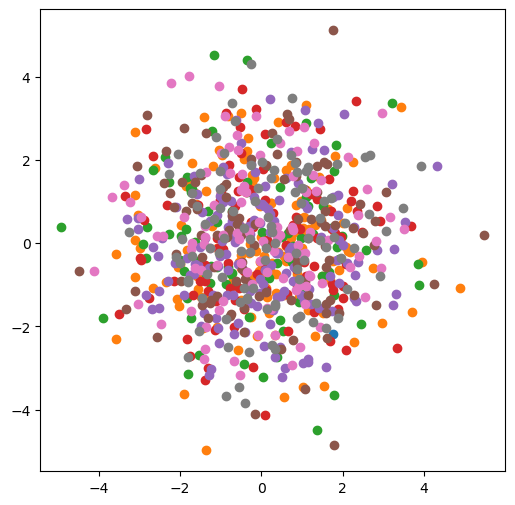

In [141]:
## WE apply pca in 2 dimentions of the embeddings of emotions to see what they look like:
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

emb = model.embedding_layer_emotion.weight.clone().detach().numpy()
print(emb)
print(emb.shape)
num_colors = 0
e = dict()
for i in range(len(emory_lookup)-1):
  name = emory_lookup[i].split('_')[0]
  
  if name not in e:
    e[name] = []
  e[name].append(i)


pca = PCA(n_components=2)
y = pca.fit_transform(emb)
for i in e.keys():
    print(i, len(e[i]))
    ax.scatter(y[e[i],0],y[e[i],1])#,y[e[i],2])


In [459]:
b = torch.tensor([[1,0,0],[1,0,0],[1,0,0]],dtype=torch.float32)
c = torch.tensor([-1,0,0])
c * b 
f = nn.CrossEntropyLoss(ignore_index = -1)
f(b,c)
print(type(c) == int)

False


In [ ]:
  emotion_counts = torch.bincount(batch['target_emotions'].view(-1), minlength=len(lookup_emory))
  class_weights = 1.0 / (emotion_counts.float() + 1e-6)  # Avoid division by zero
  class_weights /= class_weights.sum() + 1e-6  # Normalize
  #loss_fn1 = nn.CrossEntropyLoss(weight=class_weights.to(device),ignore_index=-1)
